# Введение в нейронные сети

## Урок 2. Keras

1. Попробуйте обучить, нейронную сеть на Keras (рассмотренную на уроке) на датасете fashion_mnist с другими параметрами.
2. Какого результата вы добились от нейросети?
3. Что помогло вам улучшить её точность?
4. Поработайте с документацией Keras. Попробуйте найти полезные команды Keras, неразобранные на уроке.

In [2]:
from keras.datasets import fashion_mnist
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import itertools

%matplotlib inline

In [3]:
# Зафиксируем seed
tf.keras.utils.set_random_seed(
    142
)

In [4]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()
print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000,)


Label is 1


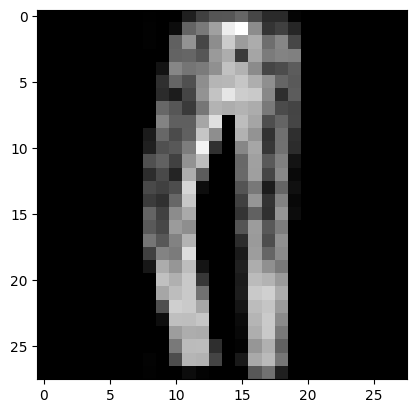

In [5]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is {y_train_labels[ind]}')

Набор из 60 000 полутоновых изображений 28х28 серого цвета 10 категорий моды, а также тестовый набор из 10 000 изображений.<br>
Классовые метки:<br>
   * 0 - футболка/клубка<br>
   * 1 - Брюки<br>
   * 2 - Пуловер<br>
   * 3 - Платье<br>
   * 4 - Пальто<br>
   * 5 - Сандал<br>
   * 6 - Рубашка<br>
   * 7 - Кроссовок<br>
   * 8 - Сумка<br>
   * 9 - Ботинок

Конвертируем значения пикселей из вида от 0 до 255 в набор значений от 0 до 1.

In [6]:
X_train.min(), X_train.max()

(0, 255)

In [7]:
# Нормировка
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

(0.0, 1.0)

In [8]:
# Вытягивание признаков
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Передача данных для обучения нейросети

In [9]:
y_train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [10]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Подбор количества нейронов для двухслойной сети

Проверим качество в зависимости от числа нейронов в слое (для 3-х слойной сети).

In [11]:
%%time
results_num = pd.DataFrame()
n_nums = []
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for n_num in list(map(lambda x: 2**x, range(0,10))):

    n_nums.append(n_num)

    model = Sequential([
        Dense(98, input_shape=(28 * 28,), activation='relu'),
        Dense(n_num, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.summary()

    # Компиляция модели
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                    epochs=7,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)


results_num['n_num'] = n_nums
results_num['train_loss'] = train_losses
results_num['test_loss'] = test_losses
results_num['train_metric'] = train_metrics
results_num['test_metric'] = test_metrics
results_num.sort_values(by='test_metric', ascending=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 98)                76930     
                                                                 
 dense_1 (Dense)             (None, 1)                 99        
                                                                 
 dense_2 (Dense)             (None, 10)                20        
                                                                 
Total params: 77,049
Trainable params: 77,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
938/938 [==============================] - 8s 4ms/step - loss: 2.1364 - accuracy: 0.1853 - val_loss: 2.0474 - val_accuracy: 0.2101
Epoch 2/7
938/938 [==============================] - 4s 4ms/step - loss: 1.9965 - accuracy: 0.2195 - val_loss: 1.9501 - val_accuracy: 0.2316
Epoch 3/7
938/938 [===============

,n_num,train_loss,test_loss,train_metric,test_metric
9,512,0.417076,0.452775,0.854400,0.8420
7,128,0.417595,0.455994,0.854733,0.8410
8,256,0.417400,0.453948,0.853667,0.8393
4,16,0.419545,0.454480,0.853917,0.8392
6,64,0.417885,0.456388,0.854150,0.8386
5,32,0.419418,0.456163,0.851450,0.8384
3,8,0.453269,0.488923,0.844217,0.8339
2,4,0.598125,0.633315,0.803950,0.7920
1,2,0.883825,0.896471,0.660750,0.6604
0,1,1.710242,1.718145,0.348467,0.3448


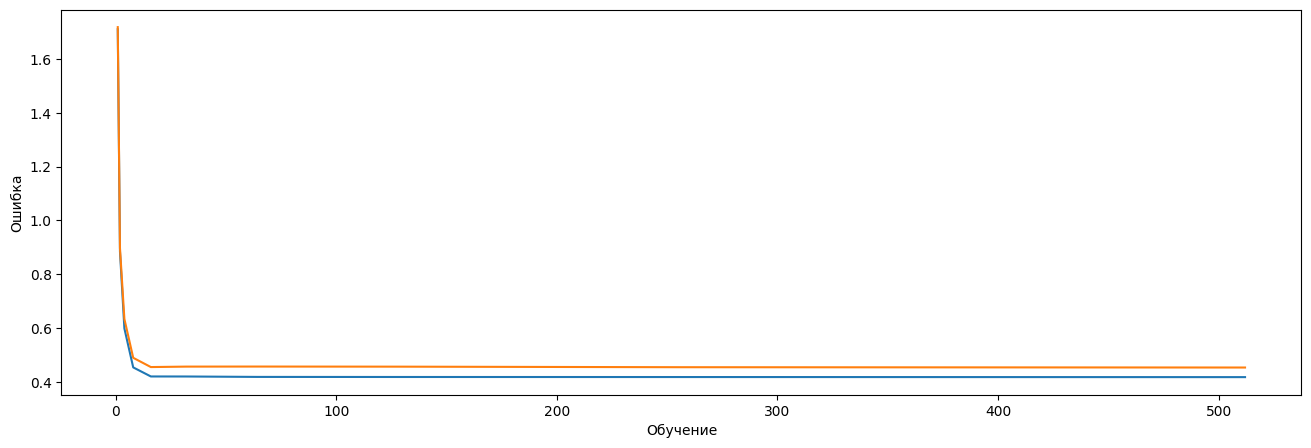

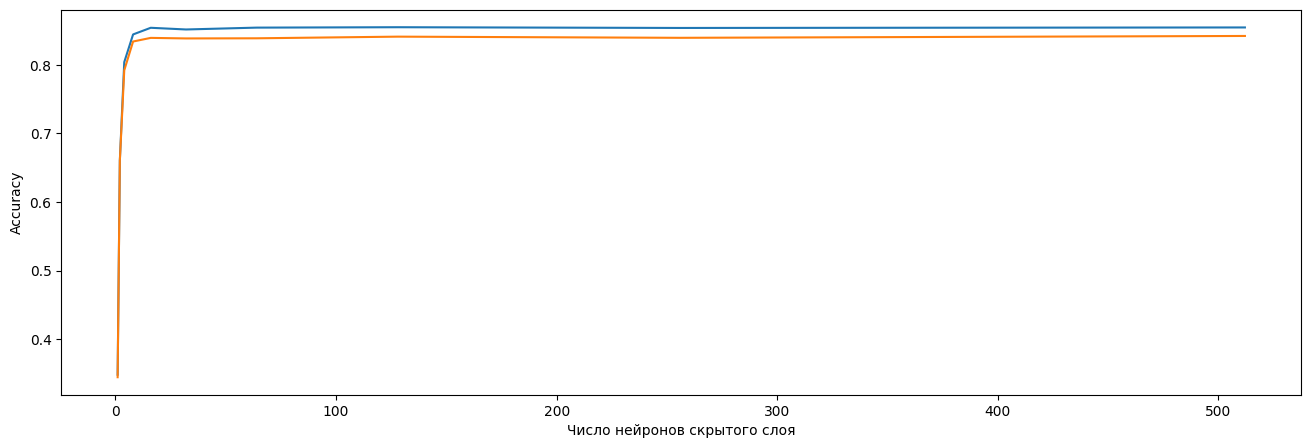

In [12]:
# Демонстрация полученных результатов
# Диаграмма точности в зависимости от обучения
plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_loss'], label='train')
plt.plot(results_num['n_num'],results_num['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_metric'], label='train')
plt.plot(results_num['n_num'],results_num['test_metric'], label='test')
plt.xlabel('Число нейронов скрытого слоя')
plt.ylabel('Accuracy')
plt.show()

Видно, что при увеличении нейронов второго слоя сначала происходило последовательное увеличение качества обучения, при этом начиная с некоторого кол-ва увеличения кол-ва нейронов почти перестало давать эффект в повышении качества.

### Подбор количества слоёв

Проверим качество в зависимости от числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых параметров)

In [13]:
%%time
results_layers = pd.DataFrame()
n_nums = [] # число нейронов скрытых слоев
n_layers = [] # число скрытых слоев
n_pars = [] # число тренируемых параметров
train_losses = [] # ошибка на тренировочной выборке
test_losses = [] # ошибка на тестовой выборке
train_metrics = [] # accuracy на тренировочной выборке
test_metrics = [] # accuracy на тестовой выборке

# Базовый размер возьмем для двухслойной сети с 512 нейронами, и будем равняться на него
# Подберём количество нейронов так, чтобы количество параметров было примерно одинаково
k_dict = {2:512, 3:162, 5:101, 10:64}
for n in [2, 3, 5, 10]:

    k = k_dict[n]
    net_size = 64 * 785 + 65 * k + (n - 2) * (k + 1) * k + (k + 1) * 10
    n_nums.append(k)
    n_pars.append(net_size)
    n_layers.append(n)

    model = Sequential()
    model.add(Dense(64, input_shape=(28 * 28,), activation='relu'))
    for i in range(n - 1):
        model.add(Dense(k, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))

    model.summary()

    # Компиляция модели
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                    epochs=7,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)


results_layers['n_layer'] = n_layers
results_layers['n_num'] = n_nums
results_layers['n_par'] = n_pars
results_layers['train_loss'] = train_losses
results_layers['test_loss'] = test_losses
results_layers['train_metric'] = train_metrics
results_layers['test_metric'] = test_metrics
results_layers.sort_values(by='test_metric', ascending=False)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                50240     
                                                                 
 dense_31 (Dense)            (None, 512)               33280     
                                                                 
 dense_32 (Dense)            (None, 10)                5130      
                                                                 
Total params: 88,650
Trainable params: 88,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
938/938 [==============================] - 6s 5ms/step - loss: 1.0260 - accuracy: 0.6718 - val_loss: 0.6982 - val_accuracy: 0.7457
Epoch 2/7
938/938 [==============================] - 3s 3ms/step - loss: 0.5881 - accuracy: 0.8015 - val_loss: 0.5625 - val_accuracy: 0.8043
Epoch 3/7
938/938 [============

,n_layer,n_num,n_par,train_loss,test_loss,train_metric,test_metric
1,3,162,88806,0.414344,0.454642,0.853083,0.8389
0,2,512,88650,0.420443,0.457556,0.853067,0.8378
2,5,101,88731,0.410881,0.454502,0.852333,0.8371
3,10,64,88330,0.426302,0.479117,0.843800,0.8244


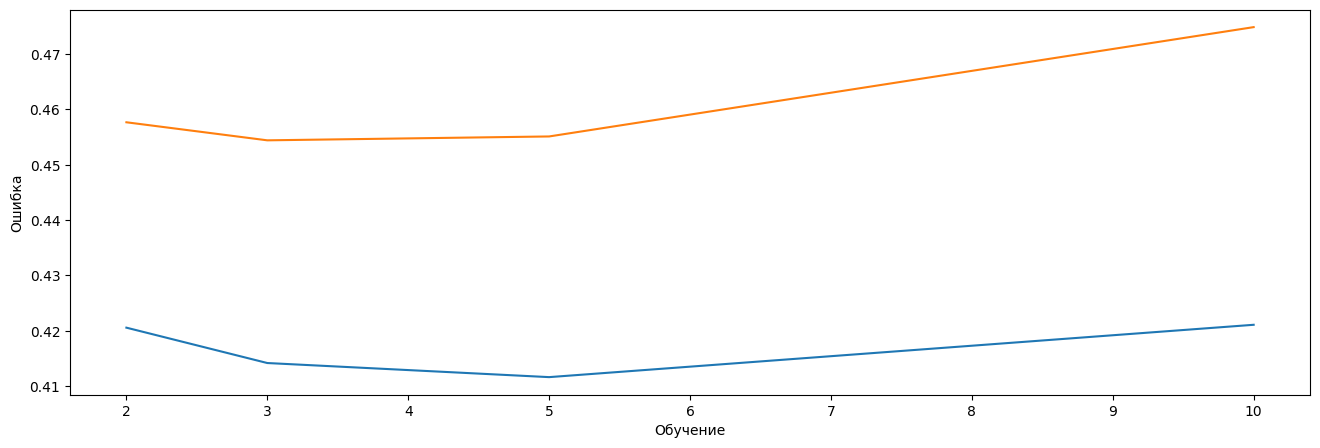

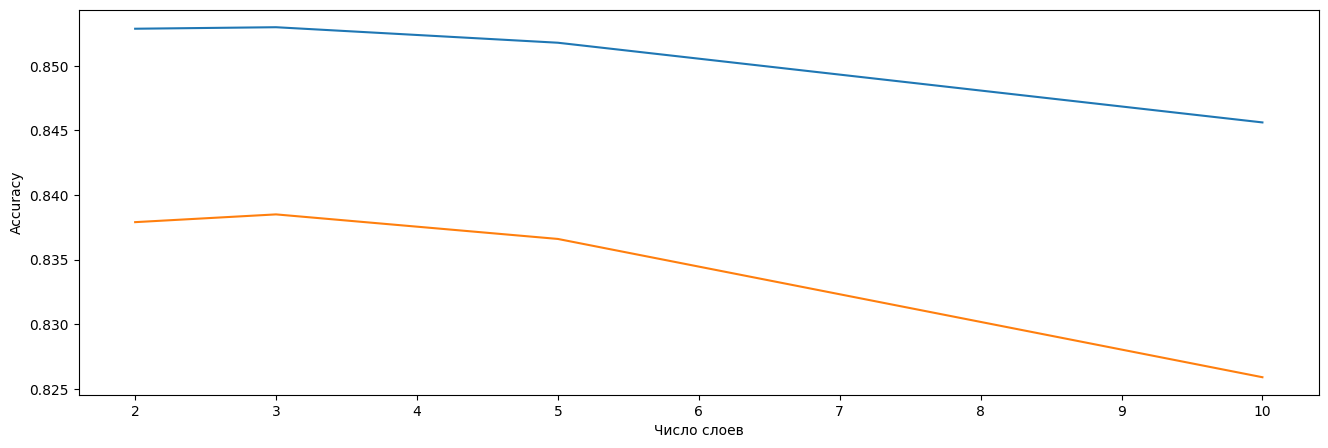

In [ ]:
# Демонстрация полученных результатов
# Диаграмма точности в зависимости от обучения
plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_loss'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_metric'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_metric'], label='test')
plt.xlabel('Число слоев')
plt.ylabel('Accuracy')
plt.show()

Лучшее качество получилось на 2 слоях с 512 нейронами.<br>
Увеличение количества слоев приводит к значительно большему переобучению сети и качество классификации далее начинает сильно падать.

### Сохранение модели и оптимизаторы

Посмотрим работу разных оптимизаторов (SGD, Adam, RMSProp) для этой модели.

Оптимизатор: SGD
Epoch 1/7
938/938 [==============================] - 3s 3ms/step - loss: 0.9947 - accuracy: 0.6798 - val_loss: 0.6955 - val_accuracy: 0.7518
Epoch 2/7
938/938 [==============================] - 3s 3ms/step - loss: 0.5983 - accuracy: 0.7935 - val_loss: 0.5720 - val_accuracy: 0.7982
Epoch 3/7
938/938 [==============================] - 3s 3ms/step - loss: 0.5257 - accuracy: 0.8185 - val_loss: 0.5399 - val_accuracy: 0.8051
Epoch 4/7
938/938 [==============================] - 4s 4ms/step - loss: 0.4894 - accuracy: 0.8288 - val_loss: 0.4957 - val_accuracy: 0.8238
Epoch 5/7
938/938 [==============================] - 3s 3ms/step - loss: 0.4654 - accuracy: 0.8375 - val_loss: 0.4847 - val_accuracy: 0.8288
Epoch 6/7
938/938 [==============================] - 3s 3ms/step - loss: 0.4474 - accuracy: 0.8444 - val_loss: 0.4636 - val_accuracy: 0.8374
Epoch 7/7
157/157 [==============================] - 0s 3ms/step - loss: 0.4603 - accuracy: 0.8389
Качество на тесте: 0.46025699377059937

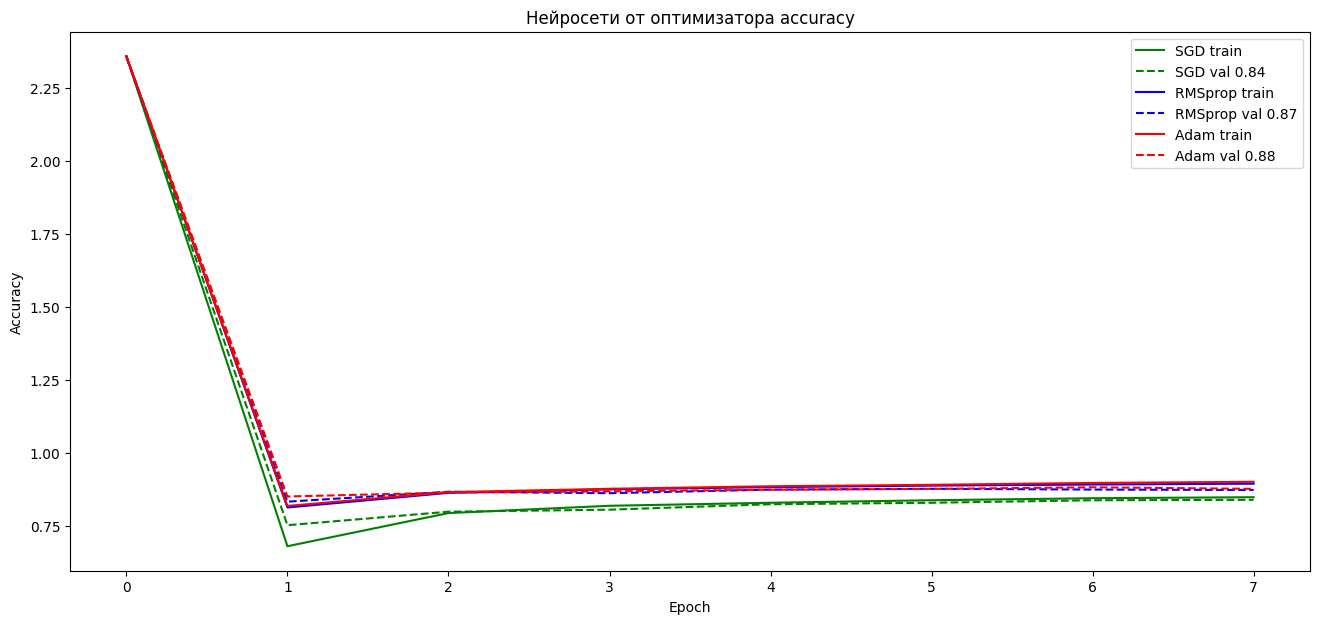

CPU times: user 1min 30s, sys: 9.71 s, total: 1min 40s
Wall time: 2min 4s


In [14]:
%%time

# создаем модель model
model = Sequential([
    Dense(64, activation='relu', input_shape=(28 * 28,)),
    Dense(512, activation='relu'),
    Dense(10, activation='sigmoid'),
])

# сохраняем ее веса (это начальная точка) model.save_weights('model.h5')
model.save_weights('model_weights.h5')

# будем сохранять модели в словарь
models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r']

num_epochs = 7
batch_size = 64

# вектор для вывода результатов
epoch = np.arange(num_epochs+1)

# будем изменять оптимизаторы
for i, i_optim in enumerate([SGD(),
                             RMSprop(),
                             Adam()]):
    print(f'Оптимизатор: {i_optim.get_config()["name"]}')

    # создаем рабочую модель  model_i, куда будем загружать эти веса (она должна быть идентичной структуры)
    model_i = Sequential([
        Dense(64, activation='relu', input_shape=(28 * 28,)),
        Dense(512, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])

    # загружаем веса model_i.load_weights('model.h5')
    model_i.load_weights('model_weights.h5')

    # компилируем model_i с одним из оптимизаторов
    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )

    # вычисляем ошибку для modeli без обучения
    h0_train = model_i.evaluate(X_train, y_train, verbose=0)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0)

    # проводим обучение модели
    h = model_i.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=1)

    # вычисляем ошибку для modeli после обучения
    loss, metric = model_i.evaluate(X_test, y_test, batch_size=64)
    print(f'Качество на тесте: {loss}, {metric}')

    # записываем обученную модель в словарь
    models[i_optim.get_config()['name']] = model_i


    # картинки
    '''
    plt.figure(figsize=(16, 7))
    plt.plot(epoch, np.log([h0_train[0]] + h.history['loss']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, np.log([h0_val[0]] + h.history['val_loss']),
             '--', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' val')
    '''

    plt.plot(epoch, ([h0_train[0]] + h.history['accuracy']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, ([h0_val[0]] + h.history['val_accuracy']),
             '--', c=colors[i],
             label=f'{model_i.optimizer.get_config()["name"]} val {metric:.2f}')

plt.legend()
plt.title('Нейросети от оптимизатора accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Результаты

Итоговое качество на тестовой выборке получилось 0.88 благодаря подбору оптимального количества скрытых слоев (1) и количества нейронов на них (512), а также выбору оптимизатора (Adam).